In [24]:
# import some general scientific Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import required PyRockWave modules
import christoffel as c
from tensor_tools import _rearrange_tensor
from coordinates import equispaced_S2_grid, sph2cart

In [2]:
# load test data
Cij = np.array([[118.8,  53.8,  53.8,   0. ,   0. ,   0. ],
                [ 53.8, 118.8,  53.8,   0. ,   0. ,   0. ],
                [ 53.8,  53.8, 118.8,   0. ,   0. ,   0. ],
                [  0. ,   0. ,   0. ,  59.4,   0. ,   0. ],
                [  0. ,   0. ,   0. ,   0. ,  59.4,   0. ],
                [  0. ,   0. ,   0. ,   0. ,   0. ,  59.4]])

density_gcm3 = 5.307

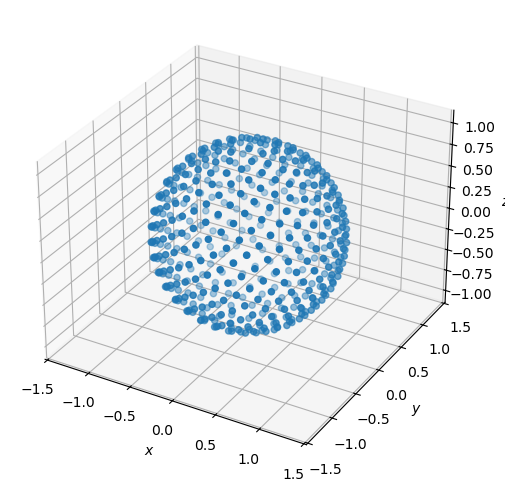

In [3]:
# create equispaced wavevectors in spherical coordinates (in radians)
azimuths, polar = equispaced_S2_grid(num_points=500)

# convert from spherical to 3d cartesian
# i.e. build unit wavevectors q (n, 3)
x, y, z = sph2cart(azimuths, polar)

# plot to test
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.scatter(x, y, z)
ax.axis('equal')
_ = ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

In [4]:
# Build array with unit wavevectors q (n, 3)
q = np.column_stack((x, y, z))
q.shape

(500, 3)

In [5]:
q

array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.62085037e-01,  0.00000000e+00,  9.86776794e-01],
       [-1.36149207e-01, -1.24723826e-01,  9.82805861e-01],
       ...,
       [-1.77356227e-01, -5.13557030e-02, -9.82805861e-01],
       [ 8.43481987e-02,  1.38408600e-01, -9.86776794e-01],
       [ 1.22464680e-16,  0.00000000e+00, -1.00000000e+00]],
      shape=(500, 3))

In [6]:
# rearrange tensor Cij → Cijkl
Cijkl = _rearrange_tensor(Cij)
Cijkl.shape

(3, 3, 3, 3)

In [7]:
# normalize Cijkl with density
# NOTE: with Cijkl in GPa and density in g/cm^3 gives (km/s)^2
Cijkl_norm = Cijkl / density_gcm3

In [8]:
# estimate the Christoffel matrix (M) for every wavevector
M = c._christoffel_matrix(q, Cijkl_norm)
M.shape

(500, 3, 3)

In [9]:
# test
M[100]

array([[12.32390136,  5.01287891,  4.02550164],
       [ 5.01287891, 17.30977474,  9.36121025],
       [ 4.02550164,  9.36121025, 15.137381  ]])

In [10]:
# estimate the eigenvalues and eigenvectors
eigenvalues, eigenvectors = c._calc_eigen(M)
eigenvalues.shape, eigenvectors.shape

((500, 3), (500, 3, 3))

In [11]:
# test
eigenvalues[100]

array([ 6.76764584,  9.76460008, 28.23881117])

In [12]:
# test
eigenvectors[100]

array([[ 0.09676888, -0.92227055, -0.37423632],
       [-0.68620119,  0.21053436, -0.69627811],
       [ 0.7209464 ,  0.32417946, -0.61248998]])

In [13]:
# COMPUTE PHASE VELOCITIES   
phase_vel = c.calc_phase_velocities(eigenvalues)  # (n,3)
phase_vel.shape

(500, 3)

In [14]:
# display the phase velocities for the first ten directions [Vs2, Vs1, Vp]
phase_vel[:10, :]

array([[3.34555889, 3.34555889, 4.73133475],
       [3.23791387, 3.34555889, 4.80564321],
       [3.23246285, 3.31988418, 4.82707054],
       [3.18106448, 3.34475848, 4.84401451],
       [3.18461118, 3.31093286, 4.86487742],
       [3.1308491 , 3.34125189, 4.87902416],
       [3.13618398, 3.30671028, 4.89908912],
       [3.08774736, 3.33364956, 4.91158365],
       [3.08657139, 3.30771696, 4.92982176],
       [3.05191422, 3.321096  , 4.94238789]])

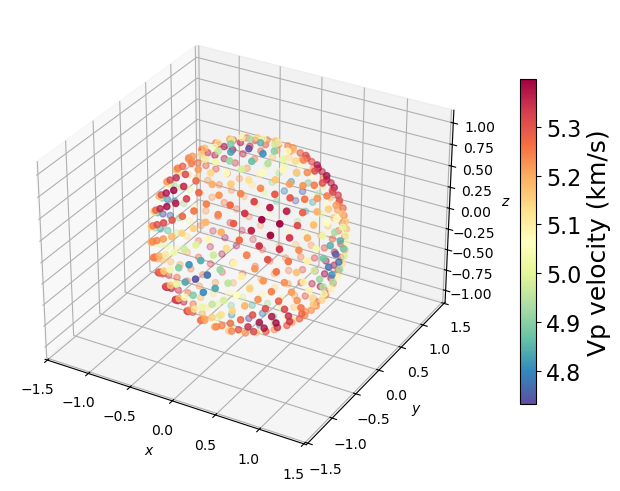

In [15]:
# plot to test
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
speed = ax.scatter(x, y, z, c=phase_vel[:, 2], cmap='Spectral_r')
ax.axis('equal')
ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

# add color bar
cbar = fig.colorbar(speed, ax=ax, shrink=0.7, location='right')
cbar.set_label('Vp velocity (km/s)', fontsize=18)
cbar.ax.tick_params(labelsize=16)

In [16]:
azimuths2, polar2 = equispaced_S2_grid(num_points=150, hemisphere='upper')
x2, y2, z2 = sph2cart(azimuths2, polar2)
wavevectors2 = np.column_stack((x2, y2, z2))
Mil2 = c._christoffel_matrix(wavevectors2, Cijkl_norm)
_, eigenvectors2 = c._calc_eigen(Mil2)

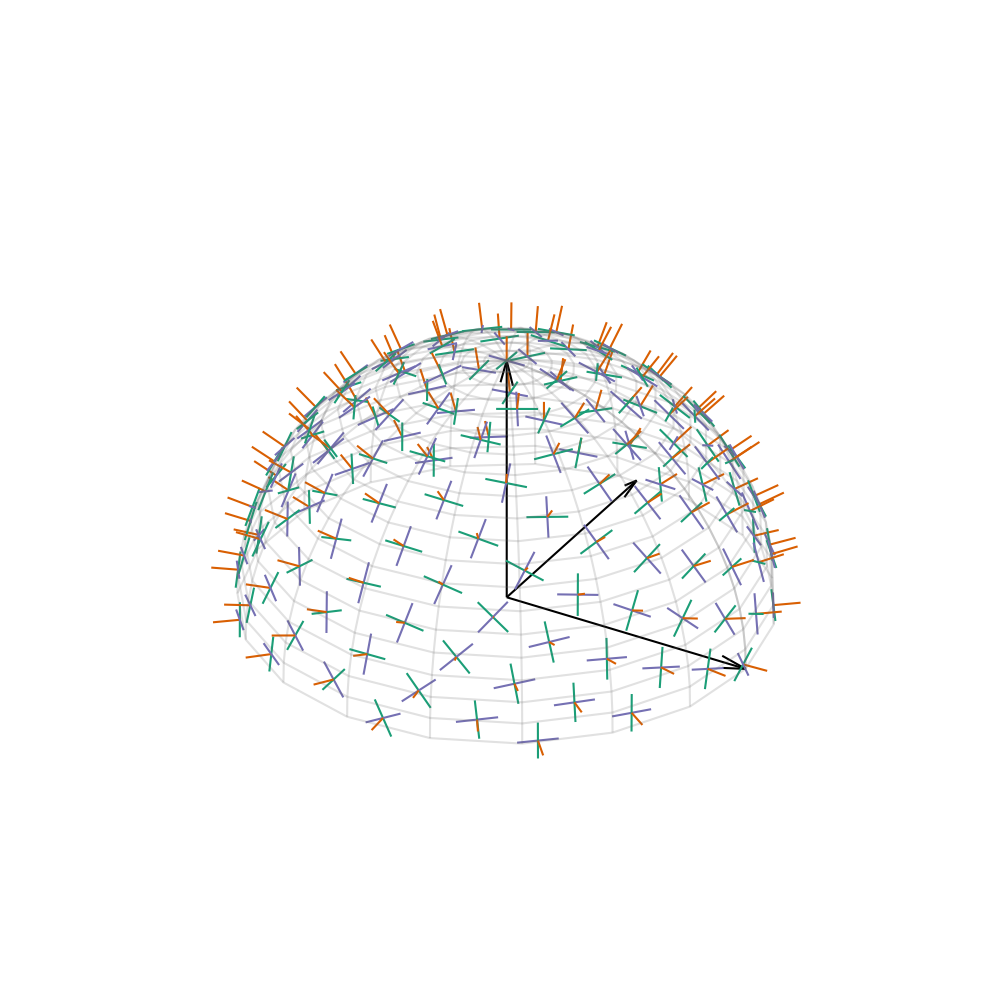

In [22]:
fig2, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})

# Plot unit sphere
u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi/2, 20)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='dimgray', alpha=0.2)

# Plot axis
origin = [0, 0, 0]
a, b, c = [1.2, 0, 0], [0, 1.2, 0], [0, 0, 1.2]
ax.quiver(*origin, *a, color='black', label='x-axis', normalize=True, arrow_length_ratio=0.1)
ax.quiver(*origin, *b, color='black', label='y-axis', normalize=True, arrow_length_ratio=0.1)
ax.quiver(*origin, *c, color='black', label='z-axis', normalize=True, arrow_length_ratio=0.1)

# Plot polarization vectors
colors = ['#1b9e77', '#7570b3']
labels = ['S1-wave', 'S2-wave']

for i in range(eigenvectors2.shape[0]):
    surface = wavevectors2[i]
    vectors = [eigenvectors2[i, :, 1], eigenvectors2[i, :, 0]]
    p_polarization = eigenvectors2[i, :, 2]

    if np.dot(p_polarization, wavevectors2[i]) < 0:
        p_polarization = -p_polarization
    
    # P-wave polarization
    ax.quiver(*surface, *p_polarization, color='#d95f02', label='P-wave', length=0.10, arrow_length_ratio=0)

    # S-wave polarization
    for vec, color, label in zip(vectors, colors, labels):
        ax.quiver(*surface, *vec, color=color, label=label, pivot='middle', length=0.15, arrow_length_ratio=0)

# Prettify the figure
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.axis("off")
#ax.legend

ax.axis('equal')  # Set an equal aspect ratio
fig2.tight_layout()

In [18]:
df = pd.DataFrame(
    {
        "azimuths_deg": np.around(np.degrees(azimuths), 3),
        "polar_deg": np.around(np.degrees(polar), 3),
        "qx": np.around(q[:, 0], 4),
        "qy": np.around(q[:, 1], 4),
        "qz": np.around(q[:, 2], 4),
        # phase velocities
        "Vp_kms": np.around(phase_vel[:, 2], 3),
        "Vs1_kms": np.around(phase_vel[:, 1], 3),
        "Vs2_kms": np.around(phase_vel[:, 0], 3),        
        # SWS
        "SWS_perc": np.around(100 * (phase_vel[:, 1] - phase_vel[:, 0]) / ((phase_vel[:, 1] + phase_vel[:, 0]) / 2), 1),
        # Vp/Vs
        "Vp/Vs1": np.around(phase_vel[:, 2] / phase_vel[:, 1], 3),
        "Vp/Vs2": np.around(phase_vel[:, 2] / phase_vel[:, 0], 3),
    }
)


df

,azimuths_deg,polar_deg,qx,qy,qz,Vp_kms,Vs1_kms,Vs2_kms,SWS_perc,Vp/Vs1,Vp/Vs2
0,0.000,0.000,0.0000,0.0000,1.0000,4.731,3.346,3.346,0.0,1.414,1.414
1,0.000,9.328,0.1621,0.0000,0.9868,4.806,3.346,3.238,3.3,1.436,1.484
2,222.492,10.640,-0.1361,-0.1247,0.9828,4.827,3.320,3.232,2.7,1.454,1.493
3,84.984,11.809,0.0179,0.2039,0.9788,4.844,3.345,3.181,5.0,1.448,1.523
4,307.477,12.874,0.1356,-0.1768,0.9749,4.865,3.311,3.185,3.9,1.469,1.528
...,...,...,...,...,...,...,...,...,...,...,...
495,111.165,167.126,-0.0804,0.2078,-0.9749,4.863,3.330,3.167,5.0,1.460,1.536
496,333.657,168.191,0.1834,-0.0908,-0.9788,4.846,3.327,3.197,4.0,1.456,1.516
497,196.149,169.360,-0.1774,-0.0514,-0.9828,4.826,3.339,3.214,3.8,1.445,1.501
498,58.641,170.672,0.0843,0.1384,-0.9868,4.807,3.331,3.252,2.4,1.443,1.478


---

In [26]:
# COMPUTE GROUP VELOCITIES
gradM = c._christoffel_gradient_matrix(q, Cijkl_norm)
group = c.calc_group_velocities(phase_vel, eigenvectors, gradM, q)

In [28]:
gradM.shape

(500, 3, 3, 3)

In [31]:
hessM = c._christoffel_matrix_hessian(Cijkl_norm)
Hλ = c._get_hessian_eigen(eigenvalues, eigenvectors, gradM, hessM)
enh = c.calc_enhancement_factor(
    Hλ, phase_vel, group["group_velocity"], group["group_speed"], q
)

In [32]:
# Power flow (already computed in group dict, but keep a dedicated function too)
pf_deg = c.calc_power_flow_angles(group["group_dir"], q)

In [36]:
group.keys()

dict_keys(['grad_eigenvalues', 'group_velocity', 'group_speed', 'group_dir', 'group_theta_deg', 'group_phi_deg', 'cos_powerflow', 'powerflow_deg'])

In [39]:
group["group_speed"]

array([[3.34555889, 3.34555889, 4.73133475],
       [4.87914496, 3.34555889, 4.29021352],
       [3.31252062, 3.74954741, 4.80528387],
       ...,
       [5.01310724, 3.61981534, 4.17800755],
       [3.41373196, 4.52720681, 4.45817964],
       [3.34555889, 3.34555889, 4.73133475]], shape=(500, 3))

In [44]:
x, y, z = sph2cart(azimuths, polar)
len(x), len(y)

(500, 500)

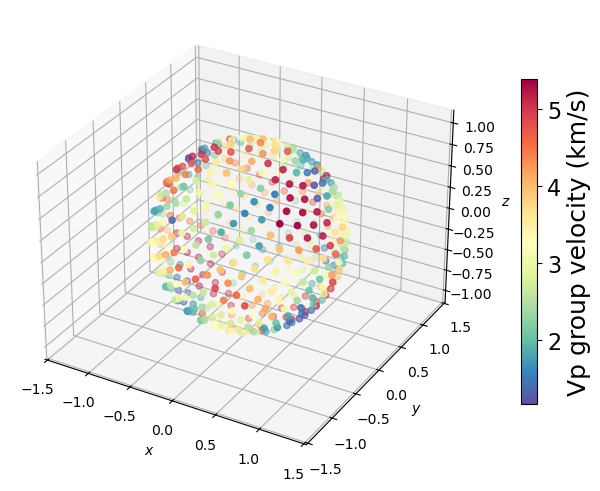

In [45]:
# plot to test
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
speed = ax.scatter(x, y, z, c=group["group_speed"][:, 2], cmap='Spectral_r')
ax.axis('equal')
ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

# add color bar
cbar = fig.colorbar(speed, ax=ax, shrink=0.7, location='right')
cbar.set_label('Vp group velocity (km/s)', fontsize=18)
cbar.ax.tick_params(labelsize=16)

In [37]:
# Assemble DataFrame
df = pd.DataFrame(
    {
        "azimuths_deg": np.around(np.degrees(azimuths), 3),
        "polar_deg": np.around(np.degrees(polar), 3),
        "qx": np.around(q[:, 0], 4),
        "qy": np.around(q[:, 1], 4),
        "qz": np.around(q[:, 2], 4),
        # group speeds
        "Vs2_group_kms": group["group_speed"][:, 0],
        "Vs1_group_kms": group["group_speed"][:, 1],
        "Vp_group_kms": group["group_speed"][:, 2],
        # power flow angles
        "Vs2_powerflow_deg": pf_deg[:, 0],
        "Vs1_powerflow_deg": pf_deg[:, 1],
        "Vp_powerflow_deg": pf_deg[:, 2],
        # enhancement factors
        "Vs2_enhancement": enh[:, 0],
        "Vs1_enhancement": enh[:, 1],
        "Vp_enhancement": enh[:, 2],
        # group spherical angles
        "Vs2_group_azimuths_deg": group["group_theta_deg"][:, 0],
        "Vs1_group_azimuths_deg": group["group_theta_deg"][:, 1],
        "Vp_group_azimuths_deg": group["group_theta_deg"][:, 2],
        "Vs2_group_polar_deg": group["group_phi_deg"][:, 0],
        "Vs1_group_polar_deg": group["group_phi_deg"][:, 1],
        "Vp_group_polar_deg": group["group_phi_deg"][:, 2],
    }
)


In [38]:
df

,azimuths_deg,polar_deg,qx,qy,qz,Vs2_group_kms,Vs1_group_kms,Vp_group_kms,Vs2_powerflow_deg,Vs1_powerflow_deg,Vp_powerflow_deg,Vs2_enhancement,Vs1_enhancement,Vp_enhancement,Vs2_group_azimuths_deg,Vs1_group_azimuths_deg,Vp_group_azimuths_deg,Vs2_group_polar_deg,Vs1_group_polar_deg,Vp_group_polar_deg
0,0.000,0.000,0.0000,0.0000,1.0000,3.345559,3.345559,4.731335,0.000000,0.000000,0.000000,0.612826,0.612826,0.186450,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1,0.000,9.328,0.1621,0.0000,0.9868,4.879145,3.345559,4.290214,26.192183,0.000000,19.768243,0.536329,0.099804,0.309347,35.520123,9.327940,10.440303,8.299864e-14,360.000000,180.000000
2,222.492,10.640,-0.1361,-0.1247,0.9828,3.312521,3.749547,4.805284,9.952580,21.082873,12.902522,0.609559,1.658603,0.342078,0.795633,21.891347,20.374811,2.516043e+02,294.624241,188.716020
3,84.984,11.809,0.0179,0.2039,0.9788,3.858249,4.224972,4.450312,13.443432,27.855466,19.347752,0.558508,0.987836,0.390804,25.252505,29.882812,18.272715,8.505839e+01,15.320019,162.338161
4,307.477,12.874,0.1356,-0.1768,0.9749,5.090070,4.006399,4.118347,26.654454,25.437685,23.987491,0.607754,0.374018,0.447695,39.507766,26.362905,16.055344,3.047650e+02,20.083063,195.354028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,111.165,167.126,-0.0804,0.2078,-0.9749,4.488756,4.243142,4.223096,21.436811,26.975239,22.710097,1.067699,0.420773,0.442175,145.705823,150.503576,162.638563,1.088384e+02,178.260446,14.270316
496,333.657,168.191,0.1834,-0.0908,-0.9788,5.373244,3.507702,4.131331,27.707216,16.678557,23.328117,0.330600,0.173419,0.398231,140.491154,162.439332,166.222086,3.354041e+02,40.066363,201.964870
497,196.149,169.360,-0.1774,-0.0514,-0.9828,5.013107,3.619815,4.178008,26.789247,14.702743,21.993887,0.383853,0.192855,0.352026,143.809246,158.473861,168.422407,1.720083e+02,234.678102,359.951228
498,58.641,170.672,0.0843,0.1384,-0.9868,3.413732,4.527207,4.458180,11.625009,26.633179,17.656466,0.185126,0.581393,0.311097,172.403799,145.190607,166.033712,3.323079e+02,33.406625,155.561494
